In [ ]:
# Basic EDA for YOLO-formatted dataset (images + labels)
# - Works with data/images and data/labels
# - Expects data/classes.txt to map class IDs to names

from pathlib import Path
import os
import re
from collections import Counter, defaultdict
from typing import List, Tuple, Dict

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# Inline plots
%matplotlib inline

# ---- Configuration ----
# Notebook is in notebooks/, project root is parent
PROJECT_ROOT = Path(os.getcwd()).parent
IMAGES_DIR = PROJECT_ROOT / "data" / "images"
LABELS_DIR = PROJECT_ROOT / "data" / "labels"
CLASSES_FILE = PROJECT_ROOT / "data" / "classes.txt"

print(f"Project root: {PROJECT_ROOT}")
print(f"Images dir:  {IMAGES_DIR}")
print(f"Labels dir:  {LABELS_DIR}")
print(f"Classes:     {CLASSES_FILE}")

# Load classes mapping if present
class_id_to_name: Dict[int, str] = {}
if CLASSES_FILE.exists():
    with open(CLASSES_FILE, "r", encoding="utf-8") as f:
        lines = [ln.strip() for ln in f.readlines() if ln.strip() != ""]
        class_id_to_name = {i: name for i, name in enumerate(lines)}
        print(f"Loaded {len(class_id_to_name)} classes")
else:
    print("classes.txt not found; will show class IDs only")


Project root: c:\Users\Omar\Desktop\ids5\object-detection-video\object_detection_project
Images dir:  c:\Users\Omar\Desktop\ids5\object-detection-video\object_detection_project\data\images
Labels dir:  c:\Users\Omar\Desktop\ids5\object-detection-video\object_detection_project\data\labels
Classes:     c:\Users\Omar\Desktop\ids5\object-detection-video\object_detection_project\data\classes.txt
Loaded 1 classes


In [ ]:
# Discover images and labels
IMAGE_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

image_paths = []
if IMAGES_DIR.exists():
    for p in IMAGES_DIR.rglob("*"):
        if p.is_file() and p.suffix.lower() in IMAGE_EXTS:
            image_paths.append(p)
image_paths = sorted(image_paths)

label_paths = []
if LABELS_DIR.exists():
    for p in LABELS_DIR.rglob("*.txt"):
        if p.is_file():
            label_paths.append(p)
label_paths = sorted(label_paths)

print(f"Found {len(image_paths)} images and {len(label_paths)} label files")

# Map image stem -> paths and label stem -> paths
img_stem_to_path = {p.stem: p for p in image_paths}
lbl_stem_to_path = {p.stem: p for p in label_paths}

# Basic coverage
images_with_labels = sorted(set(img_stem_to_path) & set(lbl_stem_to_path))
images_without_labels = sorted(set(img_stem_to_path) - set(lbl_stem_to_path))
labels_without_images = sorted(set(lbl_stem_to_path) - set(img_stem_to_path))

print(f"Images with labels:  {len(images_with_labels)}")
print(f"Images w/o labels:  {len(images_without_labels)}")
print(f"Labels w/o images:  {len(labels_without_images)}")

# Show a few samples for sanity
print("Sample image:", img_stem_to_path[images_with_labels[0]] if images_with_labels else "<none>")
print("Sample label:", lbl_stem_to_path[images_with_labels[0]] if images_with_labels else "<none>")


Found 125 images and 129 label files
Images with labels:  125
Images w/o labels:  0
Labels w/o images:  4
Sample image: c:\Users\Omar\Desktop\ids5\object-detection-video\object_detection_project\data\images\002bf8b9-images152.jpg
Sample label: c:\Users\Omar\Desktop\ids5\object-detection-video\object_detection_project\data\labels\002bf8b9-images152.txt


In [ ]:
# Parse YOLO labels and compute class/dataset stats

def parse_yolo_label_file(path: Path) -> List[Tuple[int, float, float, float, float]]:
    rows: List[Tuple[int, float, float, float, float]] = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = re.split(r"\s+", line)
            if len(parts) < 5:
                continue
            try:
                cls = int(parts[0])
                x, y, w, h = map(float, parts[1:5])
                rows.append((cls, x, y, w, h))
            except Exception:
                continue
    return rows

# Compute stats
class_counts = Counter()
images_box_counts: Dict[str, int] = {}
empty_label_files = []
invalid_label_files = []
boxes_records = []  # for DataFrame: image, cls, w, h, area, aspect

for stem in images_with_labels:
    lbl_path = lbl_stem_to_path[stem]
    try:
        rows = parse_yolo_label_file(lbl_path)
    except Exception:
        invalid_label_files.append(str(lbl_path))
        continue

    if len(rows) == 0:
        empty_label_files.append(str(lbl_path))

    images_box_counts[stem] = len(rows)
    for (cls, x, y, w, h) in rows:
        class_counts[cls] += 1
        area = w * h
        aspect = (w / h) if h > 0 else np.nan
        boxes_records.append({
            "image_stem": stem,
            "class_id": cls,
            "class_name": class_id_to_name.get(cls, str(cls)),
            "x": x, "y": y, "w": w, "h": h,
            "area": area,
            "aspect": aspect,
        })

print("Boxes per class (top 10):", class_counts.most_common(10))
print(f"Empty label files: {len(empty_label_files)}")
print(f"Invalid label files: {len(invalid_label_files)}")

boxes_df = pd.DataFrame(boxes_records)
print("boxes_df shape:", boxes_df.shape)
boxes_df.head()


Boxes per class (top 10): [(0, 125)]
Empty label files: 0
Invalid label files: 0
boxes_df shape: (125, 9)


,image_stem,class_id,class_name,x,y,w,h,area,aspect
0,002bf8b9-images152,0,omar_car,0.523043,0.461825,0.906793,0.562384,0.509966,1.612411
1,006b7950-tb1tlaxK,0,omar_car,0.504035,0.567970,0.844196,0.677840,0.572230,1.245421
2,0170f809-images115,0,omar_car,0.503118,0.561453,0.924449,0.720670,0.666223,1.282763
3,0303e805-250x1883,0,omar_car,0.509114,0.486965,0.909579,0.884544,0.804563,1.028303
4,05963b0d-images229,0,omar_car,0.492265,0.588990,0.770166,0.708366,0.545559,1.087242


sizes_df shape: (125, 7)

Image size summary:
             width       height      aspect
count   125.000000   125.000000  125.000000
mean    680.736000   563.848000    1.410436
std     538.055012   588.812009    0.315075
min     183.000000   158.000000    0.665455
25%     272.000000   183.000000    1.335052
50%     300.000000   225.000000    1.464789
75%    1200.000000   680.000000    1.600000
max    1920.000000  2048.000000    2.012658


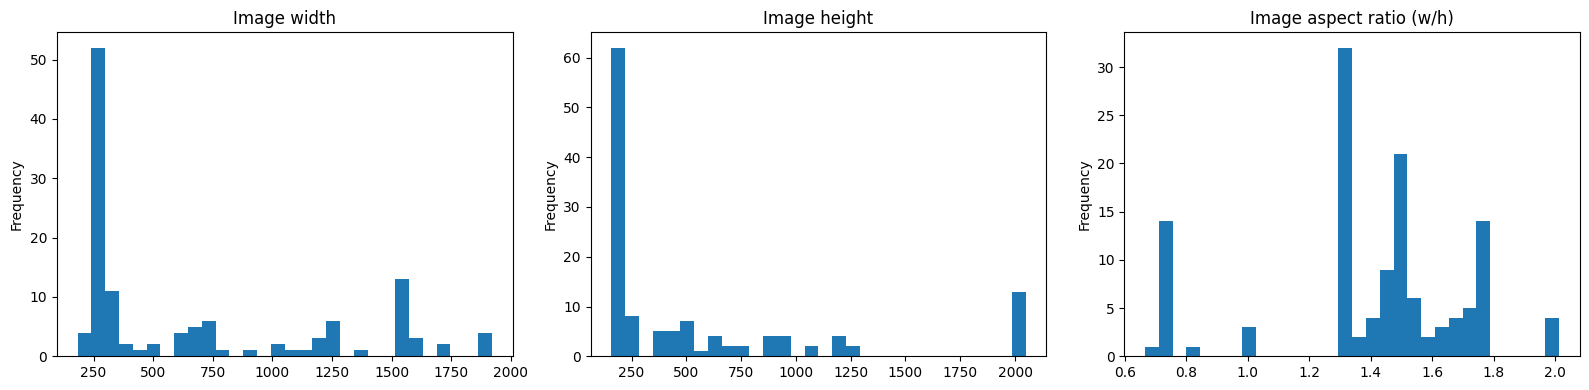


Top 10 image resolutions:
width  height
259    194       16
1536   2048      13
275    183       10
300    168        8
250    187        5
265    190        2
272    186        2
279    180        2
520    355        2
293    172        2
Name: count, dtype: int64


In [ ]:
# Image resolution and aspect ratio analysis

size_records = []
for p in image_paths:
    try:
        with Image.open(p) as im:
            w, h = im.size
    except Exception:
        w, h = None, None
    size_records.append({
        "image_path": str(p),
        "stem": p.stem,
        "width": w,
        "height": h,
        "aspect": (w / h) if (w and h and h > 0) else np.nan,
        "has_label": p.stem in images_with_labels,
        "num_boxes": images_box_counts.get(p.stem, 0),
    })

sizes_df = pd.DataFrame(size_records)
print("sizes_df shape:", sizes_df.shape)

print("\nImage size summary:")
print(sizes_df[["width", "height", "aspect"]].describe())

# Plot distributions
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
sizes_df["width"].dropna().plot(kind="hist", bins=30, ax=axes[0], title="Image width")
sizes_df["height"].dropna().plot(kind="hist", bins=30, ax=axes[1], title="Image height")
sizes_df["aspect"].dropna().plot(kind="hist", bins=30, ax=axes[2], title="Image aspect ratio (w/h)")
plt.tight_layout()
plt.show()

# Common resolutions
common_sizes = sizes_df.value_counts(subset=["width", "height"]).head(10)
print("\nTop 10 image resolutions:")
print(common_sizes)


Class distribution:


,class_id,class_name,count
0,0,omar_car,125


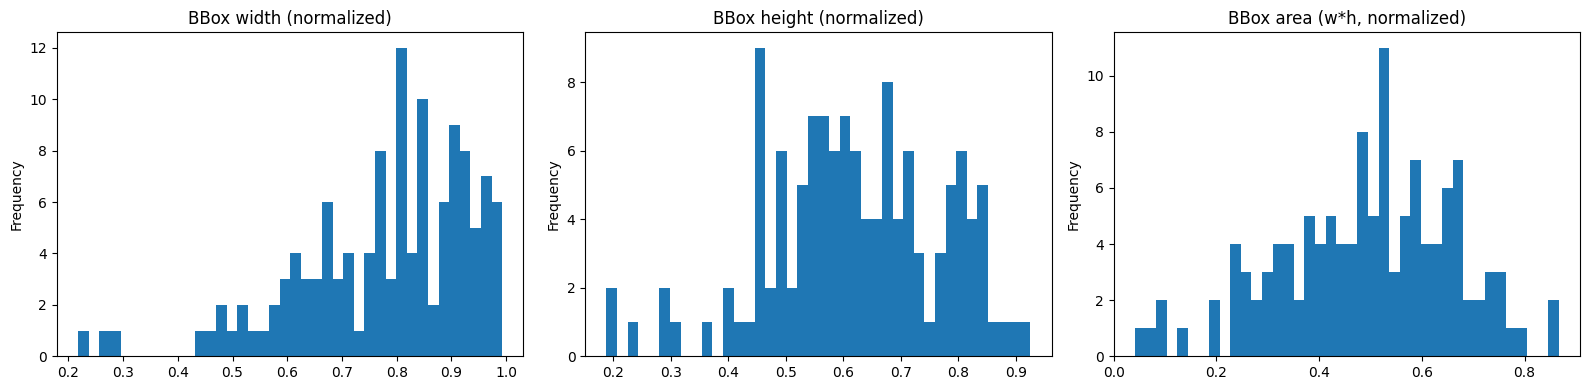


BBox size buckets:
size_bucket
large     120
medium      5
Name: count, dtype: int64


In [ ]:
# Class distribution and bbox size analysis

if len(boxes_df) > 0:
    cls_counts_df = (
        boxes_df.groupby(["class_id", "class_name"]).size().reset_index(name="count")
        .sort_values("count", ascending=False)
    )
    print("Class distribution:")
    display(cls_counts_df)

    # Bounding box width/height/area (normalized) distributions
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    boxes_df["w"].plot(kind="hist", bins=40, ax=axes[0], title="BBox width (normalized)")
    boxes_df["h"].plot(kind="hist", bins=40, ax=axes[1], title="BBox height (normalized)")
    boxes_df["area"].plot(kind="hist", bins=40, ax=axes[2], title="BBox area (w*h, normalized)")
    plt.tight_layout()
    plt.show()

    # Small/medium/large by area thresholds (yolov8 common-ish heuristic)
    # Thresholds below assume normalized area; tune as needed
    def area_bucket(a: float) -> str:
        if a < 0.02:
            return "small"
        if a < 0.15:
            return "medium"
        return "large"

    boxes_df["size_bucket"] = boxes_df["area"].apply(area_bucket)
    print("\nBBox size buckets:")
    print(boxes_df["size_bucket"].value_counts())
else:
    print("No boxes found to analyze.")


TypeError: 'list' object cannot be interpreted as an integer

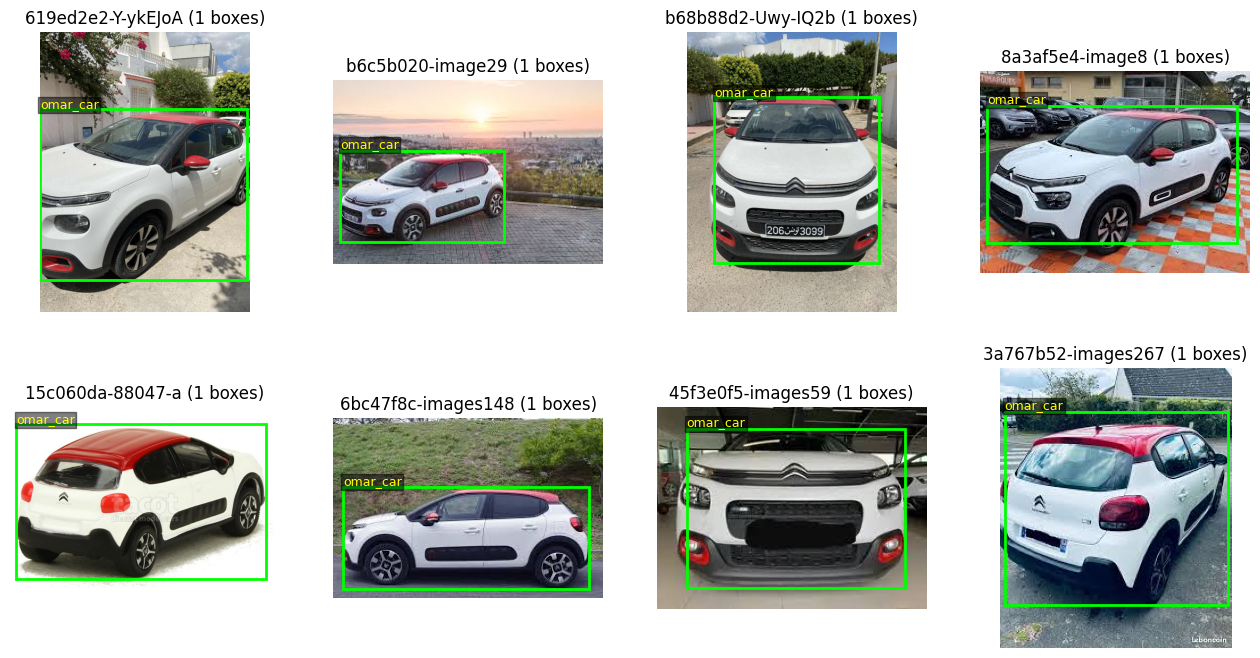

In [ ]:
# Visualize a few random samples with YOLO boxes
import random
import math

def yolo_to_xyxy(x: float, y: float, w: float, h: float, img_w: int, img_h: int) -> Tuple[int, int, int, int]:
    cx = x * img_w
    cy = y * img_h
    bw = w * img_w
    bh = h * img_h
    x1 = int(max(0, cx - bw / 2))
    y1 = int(max(0, cy - bh / 2))
    x2 = int(min(img_w - 1, cx + bw / 2))
    y2 = int(min(img_h - 1, cy + bh / 2))
    return x1, y1, x2, y2

num_samples = min(8, len(images_with_labels))
sample_stems = random.sample(images_with_labels, num_samples) if num_samples > 0 else []

cols = 4
rows = math.ceil(max(1, num_samples) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
if rows * cols == 1:
    axes = np.array([[axes]])
elif rows == 1:
    axes = np.array([axes])

for idx, stem in enumerate(sample_stems):
    ax = axes[idx // cols][idx % cols]
    img_path = img_stem_to_path[stem]
    lbl_path = lbl_stem_to_path[stem]

    with Image.open(img_path) as im:
        im_rgb = im.convert("RGB")
        img_w, img_h = im_rgb.size
        ax.imshow(im_rgb)

    rows = parse_yolo_label_file(lbl_path)
    for (cls, x, y, w, h) in rows:
        x1, y1, x2, y2 = yolo_to_xyxy(x, y, w, h, img_w, img_h)
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='lime', linewidth=2)
        ax.add_patch(rect)
        label = class_id_to_name.get(cls, str(cls))
        ax.text(x1, y1 - 2, label, color='yellow', fontsize=9, bbox=dict(facecolor='black', alpha=0.5, pad=1))

    ax.set_title(f"{stem} ({len(rows)} boxes)")
    ax.axis('off')

# Hide any unused subplots
for j in range(idx + 1, rows * cols):
    ax = axes[j // cols][j % cols]
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Quick dataset summary
num_images = len(image_paths)
num_labels = len(label_paths)
num_images_with_labels = len(images_with_labels)
num_images_without_labels = len(images_without_labels)
num_labels_without_images = len(labels_without_images)
num_boxes_total = int(boxes_df.shape[0]) if 'boxes_df' in globals() else 0

print("==== DATASET SUMMARY ====")
print(f"Images:                   {num_images}")
print(f"Label files:              {num_labels}")
print(f"Images with labels:       {num_images_with_labels}")
print(f"Images without labels:    {num_images_without_labels}")
print(f"Labels without images:    {num_labels_without_images}")
print(f"Empty label files:        {len(empty_label_files)}")
print(f"Invalid/corrupt labels:   {len(invalid_label_files)}")
print(f"Total boxes:              {num_boxes_total}")

if len(class_id_to_name) > 0 and len(boxes_df) > 0:
    by_class = boxes_df.groupby('class_name').size().sort_values(ascending=False)
    print("\nBoxes per class:")
    print(by_class)

print("\nNotes:")
print("- Ensure all images have matching label files if expected.")
print("- Check class balance and consider collecting more samples if skewed.")
print("- Review bbox size distribution; many small boxes may benefit from higher input size.")


==== DATASET SUMMARY ====
Images:                   125
Label files:              129
Images with labels:       125
Images without labels:    0
Labels without images:    4
Empty label files:        0
Invalid/corrupt labels:   0
Total boxes:              125

Boxes per class:
class_name
omar_car    125
dtype: int64

Notes:
- Ensure all images have matching label files if expected.
- Check class balance and consider collecting more samples if skewed.
- Review bbox size distribution; many small boxes may benefit from higher input size.
